In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
from scipy import optimize

    
def get_skin_depth(rho,frequency=671111):
    return (rho/(4e-7*np.pi * np.pi *frequency))**.5

def get_shape_H(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    dx = s/(resolution +1)  # grid spacing

    # Define the initial condition
    # z = np.ones((resolution, resolution), dtype=np.complex128)  # initial solution matrix
    # shape_inds = np.array([])
    # for i in range(1, resolution - 1):  # loop over the interior points in x
    #     for j in range(1, resolution - 1):  # loop over the interior points in y
    #         if mask[i, j] == 1:
    #             r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*s
    #             z[i,j] = jv(0,r*k)/jv(0,s/2*k)
    #             # shape_inds = np.append(shape_inds,(i,j))

    z = better_guess(mask,s,skin_depth)

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # for n in range(iterations):
    #     old_z = z.copy()
    #     for i in range(1, resolution - 1):  # loop over the interior points in x
    #         for j in range(1, resolution - 1):  # loop over the interior points in y
    #             if mask[i, j] == 1:  # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (old_z[i+1, j] + old_z[i-1, j] + old_z[i, j+1] + old_z[i, j-1]) * inv_denom

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] += ((z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom - z[i, j])

    # Time to iterate_new ...slower??
    # inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # inx = np.transpose(np.where(mask == 0))
    # print(inx)
    # for n in range(iterations):
    #     for i,j in inx: # loop over the interior points in   
    #                 # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
    return z

def get_shape_H_Show_Phase(mask,s,skin_depth,iterations,return_phase = False):
    k_squared = -2j / (skin_depth)**2 
    resolution = len(mask)
    dx = s/(resolution + 1)  # grid spacing
    phases = np.zeros(iterations)

    z = better_guess(mask,s,skin_depth)

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
        phases[n] = np.angle(double_Integral(z,s)/s**2-1)
    i1 = np.logical_not(phases<0)
    phases[i1]-= 2*np.pi

    fig = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.arange(iterations),phases)
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('Phase (rad)')
    ax.set_title('Phase behavior')
    # plt.show()
    if return_phase:
        return z, phases
    else:
        return z

def get_rect_H(l,w,skin_depth,resolution,iters,show = False, return_phase = False):
    big = max(l,w)
    ratio = min(l,w)/big
    mask = np.zeros([resolution+2,resolution+2],dtype=np.float64)
    for i in range(1,resolution+1):
        if abs(i/(resolution+1)-.5)< ratio/2: #so the difference from the center point (.5) is ratio/2 or less for each side
            row = [1]*(resolution + 2)
            row[0] = 0
            row[-1] = 0
            mask[i] = np.array([row])
    if show:
        return get_shape_H_Show_Phase(mask,big,skin_depth,iters, return_phase)
    else:
        return get_shape_H(mask,big,skin_depth,iters)

def double_Integral(data, d):
    n = len(data)#assumes square 2d array that has physical length of d by d meters
    dA = ((d-0)/(n-1)) * ((d-0)/(n-1))

    data_Internal = data[1:-1, 1:-1]

    # sides: up, down, left, right
    (data_u, data_d, data_l, data_r) = (data[0, 1:-1], data[-1, 1:-1], data[1:-1, 0], data[1:-1, -1])

    # corners
    (data_ul, data_ur, data_dl, data_dr) = (data[0, 0], data[0, -1], data[-1, 0], data[-1, -1])

    return dA * (np.sum(data_Internal)\
                + 0.5 * (np.sum(data_u) + np.sum(data_d) + np.sum(data_l) + np.sum(data_r))\
                + 0.25 * (data_ul + data_ur + data_dl + data_dr))

def get_area(mask,s):
    count = 0
    l = len(mask)
    for i in range(l):
        for j in range(l):
            if mask[i][j]:
                count += 1
    return (s**2)*count/((l-2)**2) #this gives area in whatever units are for s**2

def get_nearest_edge(mask,s):
    radii = np.zeros([len(mask),len(mask[0])],dtype=np.float64)
    for i in range(1, len(mask) - 1):  # loop over the interior points in x
        for j in range(1, len(mask[0]) - 1):  # loop over the interior points in y
            reach = 1
            if mask[i, j]:
                r = np.Infinity# r is defined to be the distance between centers of pixels in units of a single pixel length
                while reach < r:
                    if (not(mask[i+reach,j]) or not(mask[i-reach,j]) or not(mask[i,j+reach]) or not(mask[i,j+reach])) and r>reach:#check edge centers if odd
                            r = reach
                            break #if this ever happens, it is always the shortest path because every next point is farther away
                    for edge in range(1,reach): #then check two sqaures on either edge of edge center (eight total places to check for each distance)
                        if (not(mask[i+reach,j+edge]) or not(mask[i+reach,j-edge]) or 
                            not(mask[i-reach,j+edge]) or not(mask[i-reach,j-edge]) or 
                            not(mask[i+edge,j+reach]) or not(mask[i-edge,j+reach]) or
                            not(mask[i+edge,j+reach]) or not(mask[i-edge,j+reach])) and r**2>reach**2+edge**2:#check edge centers if odd
                            r = np.sqrt(reach**2+edge**2)
                            break # this breaks of because each next edge is farther
                    if (not(mask[i+reach,j+reach]) or not(mask[i-reach,j+reach]) or not(mask[i+reach,j-reach]) or not(mask[i-reach,j-reach])) and r>reach*2**.5:#check edge centers if odd
                            r = reach*2**.5 #check corners
                    reach += 1 #move out a layer
                radii[i,j] = r*s/len(mask)
    return radii

def better_guess(mask,s,skin_depth):
    a = np.sqrt(get_area(mask,s)/np.pi) #this is the radius of the circle with the same area of the mask
    rs = get_nearest_edge(mask,s)
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    good_guess = np.ones((resolution, resolution), dtype=np.complex128)
    i = np.logical_not(mask == 0)
    good_guess[i] = jv(0,(a-rs[i])*k)/jv(0,a*k)
    return good_guess

def underdamped(x, amp, per, phase,offset,decay):
    return amp *np.exp(-decay*x)*np.cos(2*np.pi*x/per+phase)+offset

def overdamped(x, amp1, amp2,decay,offset):
    return (amp1 +amp2*x)*np.exp(-decay*x)+offset

dx = 4.497268599869668e-05
skin depth = 0.0022507907903927655
ratio of skin depth/dx = 50.04795111543913
skin depth = 0.001061032953945969
ratio of skin depth/dx = 23.592830412146565
skin depth = 0.0007957747154594768
ratio of skin depth/dx = 17.694622809109923


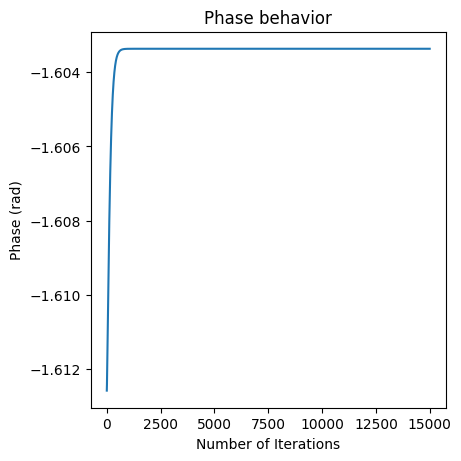

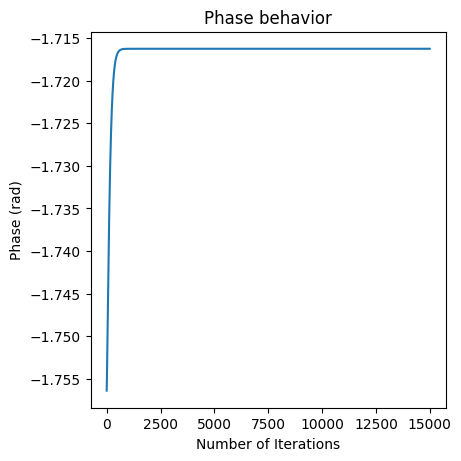

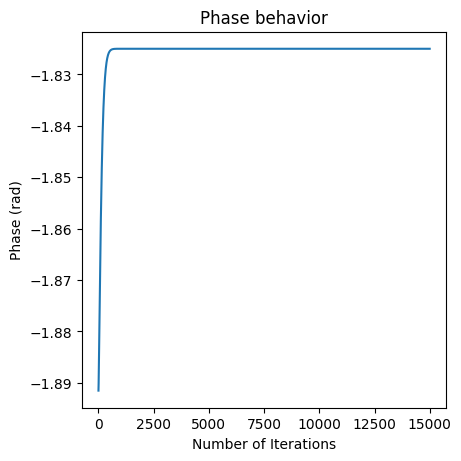

In [7]:
spacial_res =  40 # this means the resolution of the simulation will be spacial_res by spacial_res in units of pixels (must be <= picture resolution)
freq_res = 3
all_shape_area = 2e-6 #area of all the sample in units of meters squared
iters = 15000
freqs = np.array([1.5e6])
freqs = np.linspace(5e5,4e6,freq_res)
rec_ratio  = (1+np.sqrt(5))/2 #golden ratio
s = np.sqrt(rec_ratio*all_shape_area)
dx = s/spacial_res #roughly the spacial distance between pixels
magnetic_fields = np.zeros((freq_res,spacial_res,spacial_res),dtype=np.complex128)
phases = np.zeros((freq_res,iters),dtype=np.float64)
# for i, rho in enumerate(rhos):
rho = 1e-5
print('dx = '+ str(dx))
for i, freq in enumerate(freqs):
    delta = get_skin_depth(rho,freq)
    print('skin depth = '+str(delta))
    print('ratio of skin depth/dx = ' +str(delta/dx))
    magnetic_fields[i],phases[i] = get_rect_H(s,s/rec_ratio,delta,spacial_res - 2,iters,True, return_phase=True)

chis = np.zeros(freq_res,dtype=np.complex128)
for j in range(len(magnetic_fields)):
        chis[j] = double_Integral(magnetic_fields[j],s)/s**2-1

Overdamped fits [array([-7.02634222e-02,  2.32546092e-05,  9.32379713e-04, -1.89860555e+00]), array([-7.12634934e-02,  1.74480830e-04,  2.66762160e-03, -2.52171780e+00]), array([-3.07695020e-02,  2.84732013e-04,  5.83804288e-03, -2.71300226e+00])]


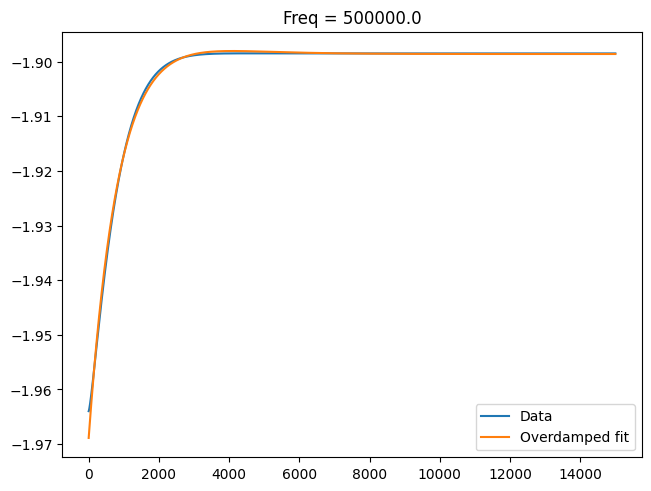

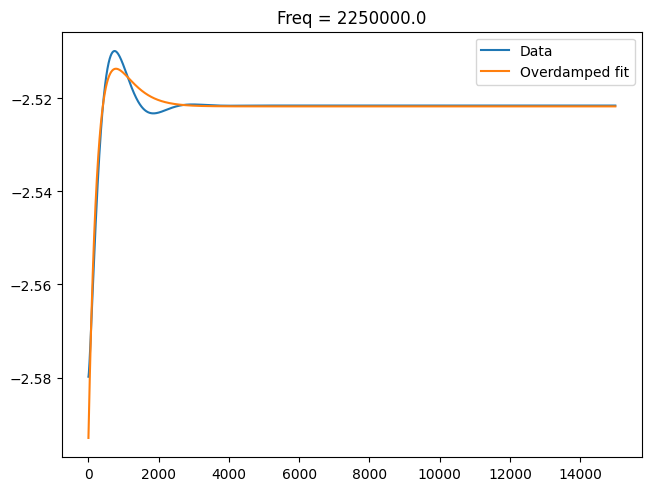

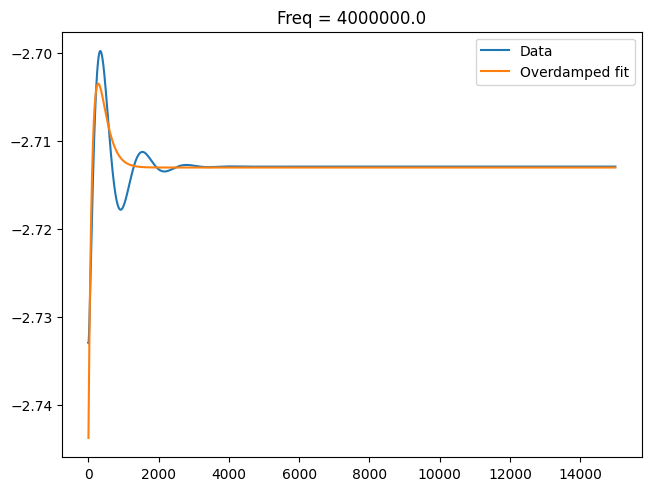

In [4]:
def plotstuff(phases,freqs):
    bestpars1 = []
    bestpars2 = []
    
    percen = 1
    for k in range(len(freqs)):
        x = np.arange(len(phases[k]))
        guesses1 = [5e-3,750,2,phases[k][-1],1e-3]
        parameterlowerbounds1 = np.array([0,0,10,-3.2,0])
        parameterupperbounds1 = np.array([1e-2,1e4,2*np.pi,-1.5,1])
        pbounds1 = np.array([parameterlowerbounds1,parameterupperbounds1])
        guesses2 = [1e-2,0,1e-3,phases[k][-1]]
        parameterlowerbounds2 = np.array([-1,-1,0,-3.2])
        parameterupperbounds2 = np.array([1,1,1e-1,-1.5])
        pbounds2 = np.array([parameterlowerbounds2,parameterupperbounds2])
        
        try:
            bestfit1 = optimize.curve_fit(underdamped,x,phases[k], guesses1, bounds=pbounds1)
            bestpars1.append(bestfit1[0])
        except Exception as error:
            pass
            # print(error)
        try:
            bestfit2 = optimize.curve_fit(overdamped,x[:int(percen*len(phases[k]))],phases[k][:int(percen*len(phases[k]))], guesses2, bounds=pbounds2)
            bestpars2.append(bestfit2[0])
        except Exception as error:
            print(error)
            
        fig3 = plt.figure(constrained_layout = True)
        cx = fig3.add_subplot(1, 1, 1)
        cx.plot(x,phases[k],label='Data')
        try:
            cx.plot(x,underdamped(x,bestpars1[k][0],bestpars1[k][1],bestpars1[k][2],bestpars1[k][3],bestpars1[k][4]),label='Underdamped fit')
            if k == 0:
                print('Underdamped fits',bestpars1)
        except Exception as error:
            pass
            # print(error)
        try:
            cx.plot(x,overdamped(x,bestpars2[k][0],bestpars2[k][1],bestpars2[k][2],bestpars2[k][3]),label='Overdamped fit')
            if k == freq_res-1:
                print('Overdamped fits',bestpars2)
        except Exception as error:
            print(error)
        cx.set_title('Freq = '+str(freqs[k]))
        cx.legend()
plotstuff(phases,freqs)

Variable spacial Resolution

C:\Users\blake\AppData\Local\Temp\ipykernel_13052\3600351306.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  magnetic_fields = np.array(magnetic_fields_list)


spacial reses =  [126.36991484 268.07107116 357.42809488]
skin depth = 0.00025164606052243516		ratio of skin depth/dx = 49.94011454481108


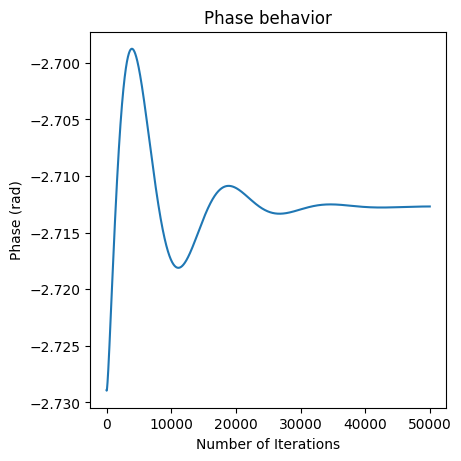

In [58]:
freq_res = 3
all_shape_area = 2e-6 #area of all the sample in units of meters squared
iters = 50000
freqs2 = np.linspace(5e5,4e6,freq_res)
rec_ratio  = (1+np.sqrt(5))/2 #golden ratio
s = np.sqrt(rec_ratio*all_shape_area)
rho = 1e-6
spacial_res =  50*s/get_skin_depth(rho,freqs2)
# i want delta/dx = 100 implies (100*s)/delta = spacial_res
magnetic_fields_list = []
for f in range(freq_res):
      magnetic_fields_list.append(np.zeros((int(spacial_res[f]),int(spacial_res[f])),dtype=np.complex128))
magnetic_fields = np.array(magnetic_fields_list)
phases2 = np.zeros((freq_res,iters),dtype=np.float64)
# for i, rho in enumerate(rhos):

print('spacial reses = ',spacial_res)
for i, freq in enumerate(freqs2):
    if i == 2:
        delta = get_skin_depth(rho,freq)
        print('skin depth = '+str(delta)+'\t\t'+'ratio of skin depth/dx = ' +str(delta*int(spacial_res[i])/s))
        magnetic_fields[i],phases2[i] = get_rect_H(s,s/rec_ratio,delta,int(spacial_res[i]) - 2,iters,True, return_phase=True)

chis = np.zeros(freq_res,dtype=np.complex128)
for j in range(len(magnetic_fields)):
        chis[j] = double_Integral(magnetic_fields[j],s)/s**2-1

-2.7128947351766675 -2.7126867025382695
`x0` is infeasible.
list index out of range
`x0` is infeasible.
list index out of range
list index out of range


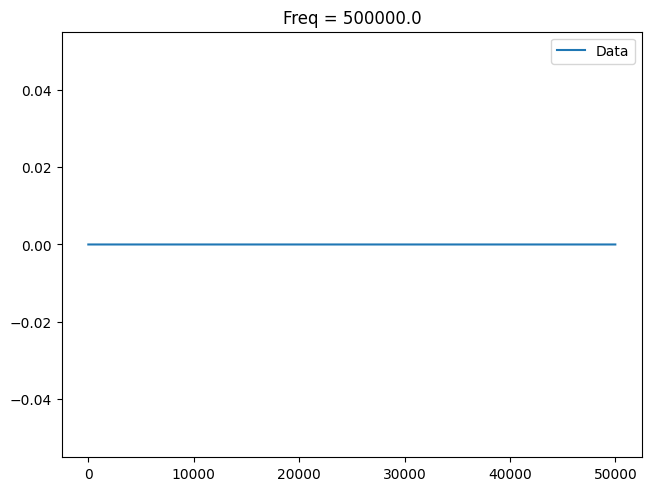

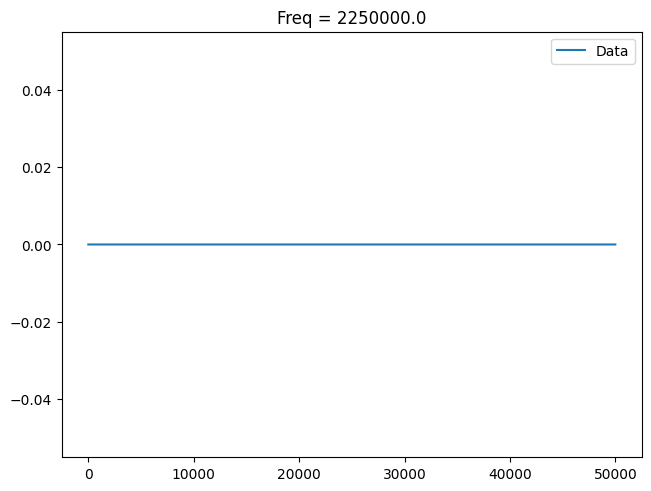

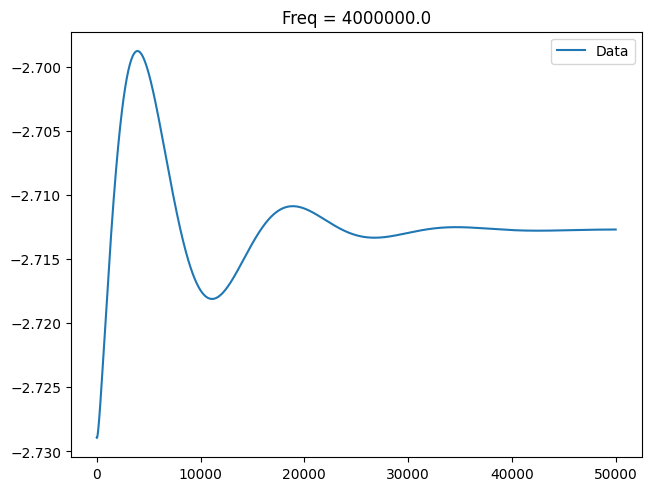

In [59]:
print(phases[2][-1],phases2[2][-1])
plotstuff(phases2,freqs2)